In [2]:
!export CUDA_VISIBLE_DEVICES=1,2,3,4,5,6

In [20]:
import copy

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn import metrics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

START_TOKEN = "<START>"
STOP_TOKEN = "<STOP>"
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

SPECIAL_TOKENS = [START_TOKEN, STOP_TOKEN, PAD_TOKEN]


train_df = pd.read_csv("hw_3_train_data.csv")

NameError: name 'read_glove_vector' is not defined

In [4]:
def get_free_gpu():
    available_mem = []
    for i in range(6):
        t = torch.cuda.get_device_properties(i).total_memory
        r = torch.cuda.memory_reserved(i)
        a = torch.cuda.memory_allocated(i)
        available_mem.append(t - r)

    return int(np.argmax(available_mem))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
if torch.cuda.is_available():
    free_gpu_id = get_free_gpu()
    torch.cuda.set_device(free_gpu_id)

using cuda


In [29]:
def read_glove_vector(glove_vec):
    with open(glove_vec, "r", encoding="UTF-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

    return word_to_vec_map


glove_map = read_glove_vector("glove.6B.50d.txt")

50

In [ ]:
glove_100d_map = read_glove_vector("glove.6B.100d.txt")

In [5]:
def tokenize(corpus, callback=lambda sent: sent.split()):
    return [callback(sent) for sent in corpus]


def add_start_stop_tokens(corpus):
    return [[START_TOKEN] + sent + [STOP_TOKEN] for sent in corpus]


def padding(corpus, seq_len):
    for sent in corpus:
        while len(sent) < seq_len:
            sent.append(PAD_TOKEN)
        while len(sent) > seq_len:
            sent.pop()
    return corpus


def build_vocab(corpus):
    vocab = set()
    for sent in corpus:
        vocab.update(set(sent))
    vocab = list(vocab) + [UNK_TOKEN]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word2idx, idx2word


def convert_to_idx(corpus, word2idx):
    return [[word2idx.get(word, "<UNK>") for word in sent] for sent in corpus]

In [6]:
# Data Preprocessing
# Create Dataset class
class UtteranceSlotDataset(Dataset):
    def __init__(self, utterances, slots, seq_len=None):
        # tokenization
        utterances = tokenize(utterances)
        slots = tokenize(slots)

        # adding start and stop tokens
        utterances = add_start_stop_tokens(utterances)
        slots = add_start_stop_tokens(slots)

        self.unpad_utterances = copy.deepcopy(utterances)
        self.unpad_slots = copy.deepcopy(slots)

        # padding
        self.seq_len = seq_len
        if not seq_len:
            self.seq_len = len(max(utterances, key=lambda sent: len(sent)))
        utterances = padding(utterances, self.seq_len)
        slots = padding(slots, self.seq_len)

        # get vocab for both utterance and slot
        self.vocab, self.word2idx, self.idx2word = build_vocab(utterances)
        self.slot_list, self.slot2idx, self.idx2slot = build_vocab(slots)

        # convert to index space
        utterances = convert_to_idx(utterances, self.word2idx)
        slots = convert_to_idx(slots, self.slot2idx)

        # Convert arrays to torch tensors
        self.X = torch.tensor(utterances).to(device)
        self.y = torch.tensor(slots).to(device)

    # Must have
    def __len__(self):
        return len(self.y)

    # Must have
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [40]:
from utils import get_one_hot_matrix, create_emb_layer


def get_glove_matrix(glove_map, vocab):
    matrix_len = len(vocab)
    emb_dim = len(list(glove_map.values())[0])
    weights_matrix = np.zeros((matrix_len, emb_dim))
    for i, word in enumerate(vocab):
        try:
            weights_matrix[i] = glove_map[word]
        except KeyError:
            if word in [PAD_TOKEN, START_TOKEN, STOP_TOKEN]:
                weights_matrix[i] = np.zeros((emb_dim,))
            else:
                weights_matrix[i] = np.random.normal(
                    scale=0.6, size=(emb_dim,)
                )
    return weights_matrix

In [8]:
from models import BaselineModel, RNNTwoLayerModel


class GRUModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        seq_len,
        emb_layer,
    ):
        super(GRUModel, self).__init__()
        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len

        # Defining the layers
        # Embedding Layer
        self.emb_layer = emb_layer
        # RNN Layer
        self.rnn = nn.GRUCell(input_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.emb_layer(x)

        hiddens = []

        # Initializing hidden state for first input
        hidden = torch.zeros(batch_size, self.output_size).to(device)

        for t in range(self.seq_len):
            hidden = self.rnn(out[:, t, :], hidden)
            # make an additional dimension
            hiddens.append(torch.unsqueeze(hidden, dim=2))

        # concat all the hidden layer
        hiddens = torch.cat(hiddens, dim=2)
        out = F.softmax(hiddens, dim=1)
        return out


class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        seq_len,
        emb_layer,
    ):
        super(LSTMModel, self).__init__()
        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len

        # Defining the layers
        # Embedding Layer
        self.emb_layer = emb_layer
        # RNN Layer
        self.rnn = nn.LSTMCell(input_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.emb_layer(x)

        hiddens = []

        # Initializing hidden state for first input
        hidden = torch.zeros(batch_size, self.output_size).to(device)
        cell = torch.zeros(batch_size, self.output_size).to(device)

        for t in range(self.seq_len):
            hidden, cell = self.rnn(out[:, t, :], (hidden, cell))
            # make an additional dimension
            hiddens.append(torch.unsqueeze(hidden, dim=2))

        # concat all the hidden layer
        hiddens = torch.cat(hiddens, dim=2)
        out = F.softmax(hiddens, dim=1)
        return out

using cuda


In [9]:
# Evaluation
def evaluate(true, pred, output_dict=False):
    gold = [slot for sequence in true for slot in sequence]
    pred = [slot for sequence in pred for slot in sequence]
    return metrics.classification_report(
        gold, pred, output_dict=output_dict, zero_division=0
    )


def inference(model, val_X):
    val_pred = model(val_X)
    val_pred = torch.argmax(val_pred, dim=1)
    return val_pred


def val_accuracy(model, val_set, utterance_slot_dataset):

    val_X = utterance_slot_dataset.X[val_set.indices]
    val_y = utterance_slot_dataset.y[val_set.indices]
    val_pred = inference(model, val_X)

    input_seqs = [
        utterance_slot_dataset.unpad_utterances[indice]
        for indice in val_set.indices
    ]
    trues = [
        utterance_slot_dataset.unpad_slots[indice]
        for indice in val_set.indices
    ]
    preds = convert_to_token(
        val_pred.tolist(), utterance_slot_dataset.idx2slot
    )

    input_seqs, preds, trues = process_output_corpus(input_seqs, preds, trues)

    return evaluate(trues, preds, output_dict=True)["accuracy"]

In [10]:
train_utterances = list(train_df["utterances"])
train_slots = list(train_df["IOB Slot tags"])
utterance_slot_dataset = UtteranceSlotDataset(
    train_utterances,
    train_slots,
    seq_len=int(np.max([len(sent.split()) for sent in train_utterances])) + 10,
)
val_len = int(len(utterance_slot_dataset) * 0.3)
train_set, val_set = random_split(
    utterance_slot_dataset, [len(utterance_slot_dataset) - val_len, val_len]
)

In [11]:
# Define hyperparameters

## Model
num_classes = len(utterance_slot_dataset.slot2idx)
seq_len = utterance_slot_dataset.seq_len

## Training
batch_size = 2048


train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
)

all_train_loader = DataLoader(
    dataset=utterance_slot_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [12]:
from train import train

10/500:	batch loss:  3.3388843536376953	train loss:  3.3290576934814453	val loss:  3.3293864727020264	train accuracy:  0.7627766599597585	val accuracy:  0.7604437101722917	train joint accuracy:  0.05576679340937896	val joint accuracy:  0.05333333333333334
20/500:	batch loss:  3.285891056060791	train loss:  3.284446954727173	val loss:  3.285576581954956	train accuracy:  0.8142857142857143	val accuracy:  0.7974982298796318	train joint accuracy:  0.17553865652724968	val joint accuracy:  0.1688888888888889
30/500:	batch loss:  3.2800722122192383	train loss:  3.2799324989318848	val loss:  3.2813656330108643	train accuracy:  0.8455734406438632	val accuracy:  0.8121312249232948	train joint accuracy:  0.30671736375158426	val joint accuracy:  0.2414814814814815
40/500:	batch loss:  3.279137372970581	train loss:  3.2790913581848145	val loss:  3.28076171875	train accuracy:  0.8632796780684104	val accuracy:  0.8288883644087798	train joint accuracy:  0.36185044359949303	val joint accuracy:  0.27703

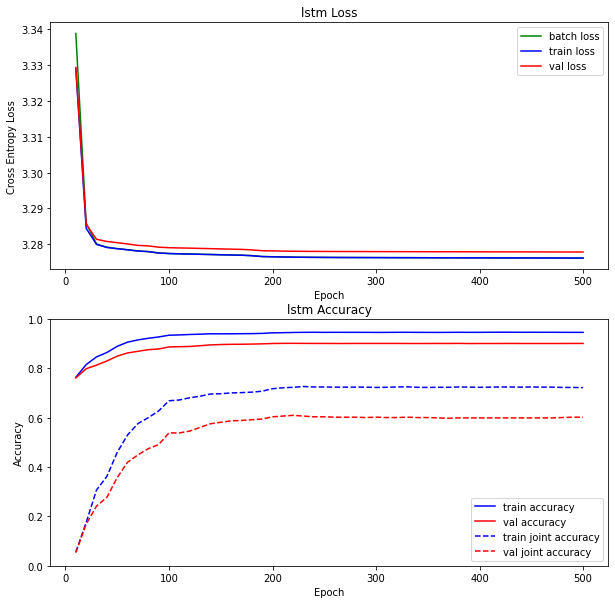

In [14]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

lstm_model = LSTMModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
lstm_reports = train(
    model=lstm_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(lstm_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="lstm",
)

10/500:	batch loss:  3.291947841644287	train loss:  3.287147283554077	val loss:  3.288084030151367	train accuracy:  0.646579476861167	val accuracy:  0.6332310597120604	train joint accuracy:  0.035487959442332066	val joint accuracy:  0.023703703703703703
20/500:	batch loss:  3.2785937786102295	train loss:  3.278151750564575	val loss:  3.2793846130371094	train accuracy:  0.8878269617706237	val accuracy:  0.8531980174651876	train joint accuracy:  0.5063371356147022	val joint accuracy:  0.42962962962962964
30/500:	batch loss:  3.2755136489868164	train loss:  3.2753708362579346	val loss:  3.2768361568450928	train accuracy:  0.9227364185110664	val accuracy:  0.8812839273070568	train joint accuracy:  0.6666666666666666	val joint accuracy:  0.5348148148148149
40/500:	batch loss:  3.274329662322998	train loss:  3.2742984294891357	val loss:  3.275815486907959	train accuracy:  0.923440643863179	val accuracy:  0.8815199433561483	train joint accuracy:  0.6666666666666666	val joint accuracy:  0.5348

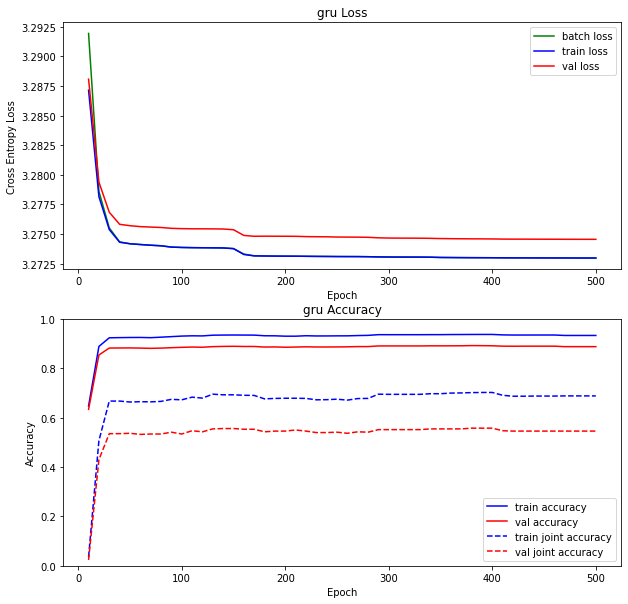

In [15]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

gru_model = GRUModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
gru_reports = train(
    model=gru_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(gru_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="gru",
)

10/500:	batch loss:  3.3301727771759033	train loss:  3.320167064666748	val loss:  3.3206725120544434	train accuracy:  0.7361167002012072	val accuracy:  0.7231531744158602	train joint accuracy:  0.12991128010139416	val joint accuracy:  0.1037037037037037
20/500:	batch loss:  3.2834396362304688	train loss:  3.2823309898376465	val loss:  3.2830193042755127	train accuracy:  0.8953722334004024	val accuracy:  0.8633467075761152	train joint accuracy:  0.523447401774398	val joint accuracy:  0.45037037037037037
30/500:	batch loss:  3.2771902084350586	train loss:  3.276909589767456	val loss:  3.2777252197265625	train accuracy:  0.9142857142857143	val accuracy:  0.8850601840925183	train joint accuracy:  0.5994930291508238	val joint accuracy:  0.5155555555555555
40/500:	batch loss:  3.2752325534820557	train loss:  3.275106430053711	val loss:  3.276008367538452	train accuracy:  0.921830985915493	val accuracy:  0.8916686334670758	train joint accuracy:  0.6273764258555133	val joint accuracy:  0.54370

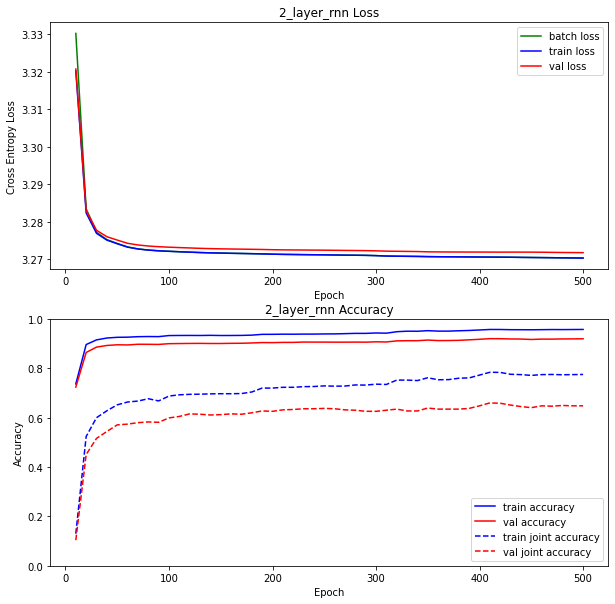

In [16]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

rnn_model = RNNTwoLayerModel(
    input_size=embedding_dim,
    hidden_size=32,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
rnn_2_layer_report = train(
    model=rnn_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(rnn_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="2_layer_rnn",
)

10/500:	batch loss:  3.290266752243042	train loss:  3.2848284244537354	val loss:  3.28590989112854	train accuracy:  0.9262575452716297	val accuracy:  0.886948312485249	train joint accuracy:  0.6742712294043093	val joint accuracy:  0.5496296296296296
20/500:	batch loss:  3.271899461746216	train loss:  3.2716729640960693	val loss:  3.2731735706329346	train accuracy:  0.921830985915493	val accuracy:  0.8791597828652349	train joint accuracy:  0.629277566539924	val joint accuracy:  0.5022222222222222
30/500:	batch loss:  3.2711684703826904	train loss:  3.271153450012207	val loss:  3.2726993560791016	train accuracy:  0.9206237424547283	val accuracy:  0.8786877507670522	train joint accuracy:  0.6185044359949303	val joint accuracy:  0.49777777777777776
40/500:	batch loss:  3.271094560623169	train loss:  3.2710890769958496	val loss:  3.2726664543151855	train accuracy:  0.9207243460764587	val accuracy:  0.8786877507670522	train joint accuracy:  0.6242078580481623	val joint accuracy:  0.500740740

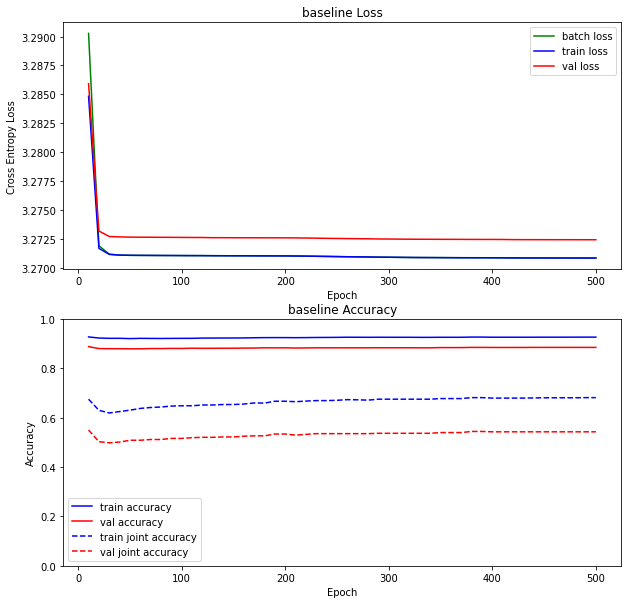

In [17]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

val_model = BaselineModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
baseline_report = train(
    model=val_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(val_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="baseline",
)

10/500:	val accuracy:  0.7080432172869148	loss:  3.426575183868408
20/500:	val accuracy:  0.7258103241296519	loss:  3.4212117195129395
30/500:	val accuracy:  0.7267707082833134	loss:  3.4151108264923096
40/500:	val accuracy:  0.7267707082833134	loss:  3.4084339141845703
50/500:	val accuracy:  0.7267707082833134	loss:  3.4017345905303955
60/500:	val accuracy:  0.7267707082833134	loss:  3.395993232727051
70/500:	val accuracy:  0.7270108043217287	loss:  3.3908004760742188
80/500:	val accuracy:  0.7272509003601441	loss:  3.386258363723755
90/500:	val accuracy:  0.7277310924369748	loss:  3.3822789192199707
100/500:	val accuracy:  0.7294117647058823	loss:  3.378302574157715
110/500:	val accuracy:  0.731812725090036	loss:  3.374307870864868
120/500:	val accuracy:  0.7349339735894358	loss:  3.369905471801758
130/500:	val accuracy:  0.7414165666266507	loss:  3.365508556365967
140/500:	val accuracy:  0.7418967587034814	loss:  3.360661506652832
150/500:	val accuracy:  0.7414165666266507	loss:  3.

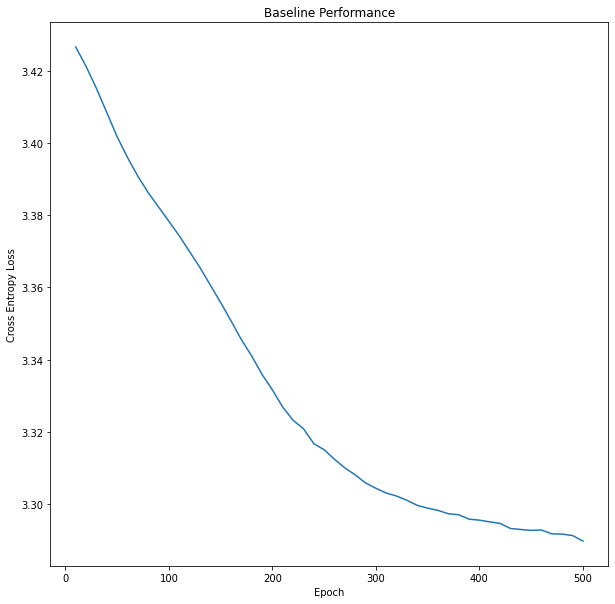

In [223]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

test_model = RNNModel(
    input_size=embedding_dim,
    hidden_size=32,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)

10/500:	batch loss:  3.4077892303466797	train loss:  3.402653694152832	val loss:  3.402599573135376	train accuracy:  0.572635814889336	val accuracy:  0.5749350955864999	train joint accuracy:  0.025348542458808618	val joint accuracy:  0.017777777777777778
20/500:	batch loss:  3.3648359775543213	train loss:  3.3611037731170654	val loss:  3.360934257507324	train accuracy:  0.7026156941649899	val accuracy:  0.7122964361576587	train joint accuracy:  0.042458808618504436	val joint accuracy:  0.035555555555555556
30/500:	batch loss:  3.3381145000457764	train loss:  3.3364384174346924	val loss:  3.336217164993286	train accuracy:  0.4992957746478873	val accuracy:  0.5114467783809299	train joint accuracy:  0.015842839036755388	val joint accuracy:  0.014814814814814815
40/500:	batch loss:  3.3241231441497803	train loss:  3.322866916656494	val loss:  3.322638511657715	train accuracy:  0.29014084507042254	val accuracy:  0.29289591692235073	train joint accuracy:  0.005069708491761723	val joint accur

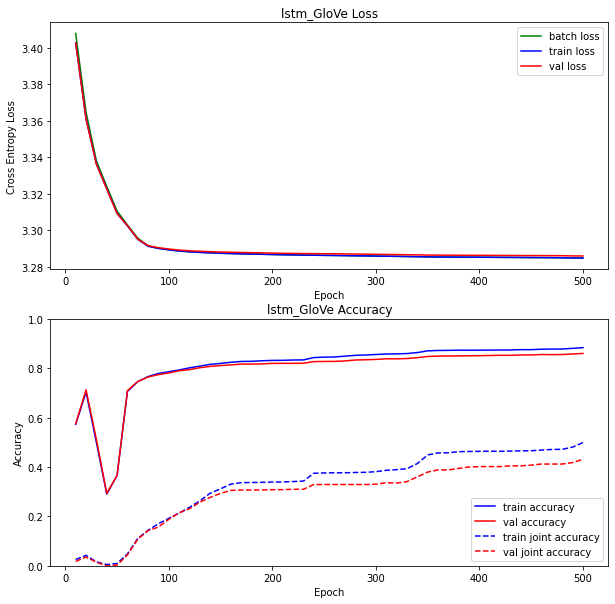

In [25]:
# LSTM + GloVe
glove_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_glove_matrix(glove_map, utterance_slot_dataset.vocab)
)

lstm_glove_model = LSTMModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=glove_emb_layer,
).to(device)
lstm_glove_reports = train(
    model=lstm_glove_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(lstm_glove_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="lstm_GloVe",
)

10/2000:	batch loss:  3.397857427597046	train loss:  3.3916149139404297	val loss:  3.3917062282562256	train accuracy:  0.36227364185110666	val accuracy:  0.353788057587916	train joint accuracy:  0.011406844106463879	val joint accuracy:  0.002962962962962963
20/2000:	batch loss:  3.3434083461761475	train loss:  3.3387694358825684	val loss:  3.338759422302246	train accuracy:  0.717907444668008	val accuracy:  0.7198489497285815	train joint accuracy:  0.052598225602027884	val joint accuracy:  0.05185185185185185
30/2000:	batch loss:  3.31646990776062	train loss:  3.31504225730896	val loss:  3.3150317668914795	train accuracy:  0.7193158953722334	val accuracy:  0.726457399103139	train joint accuracy:  0.052598225602027884	val joint accuracy:  0.05037037037037037
40/2000:	batch loss:  3.303189516067505	train loss:  3.3016109466552734	val loss:  3.3017454147338867	train accuracy:  0.7509054325955734	val accuracy:  0.7488789237668162	train joint accuracy:  0.050697084917617236	val joint accurac

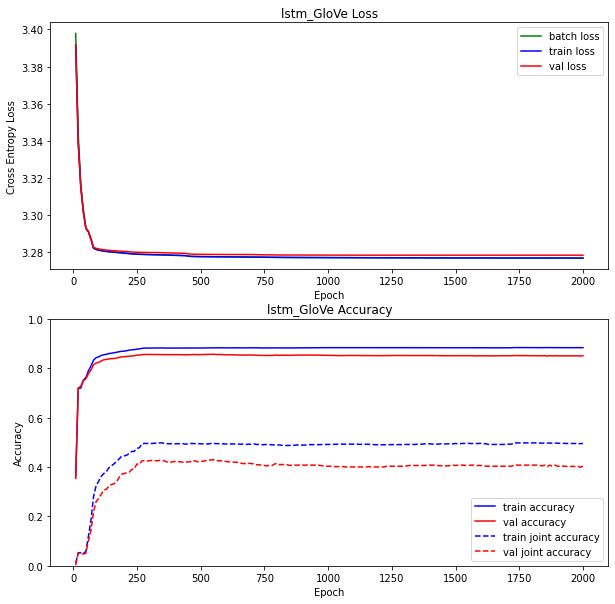

In [42]:
# LSTM + GloVe
glove_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_glove_matrix(glove_100d_map, utterance_slot_dataset.vocab)
)

lstm_glove100_model = LSTMModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=glove_emb_layer,
).to(device)
lstm_glove100_reports = train(
    model=lstm_glove100_model,
    n_epochs=2000,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(lstm_glove100_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="lstm_GloVe",
)

10/500:	batch loss:  3.3992741107940674	train loss:  3.395627737045288	val loss:  3.3955862522125244	train accuracy:  0.5149899396378269	val accuracy:  0.528911966013689	train joint accuracy:  0.008871989860583017	val joint accuracy:  0.002962962962962963
20/500:	batch loss:  3.3646161556243896	train loss:  3.3601341247558594	val loss:  3.3600690364837646	train accuracy:  0.6792756539235413	val accuracy:  0.6931791361812604	train joint accuracy:  0.04182509505703422	val joint accuracy:  0.04148148148148148
30/500:	batch loss:  3.325028896331787	train loss:  3.3217742443084717	val loss:  3.3217365741729736	train accuracy:  0.6736418511066399	val accuracy:  0.6842105263157895	train joint accuracy:  0.039923954372623575	val joint accuracy:  0.03259259259259259
40/500:	batch loss:  3.300013303756714	train loss:  3.298449993133545	val loss:  3.2984366416931152	train accuracy:  0.7234406438631791	val accuracy:  0.7255133349067736	train joint accuracy:  0.048795944233206594	val joint accuracy

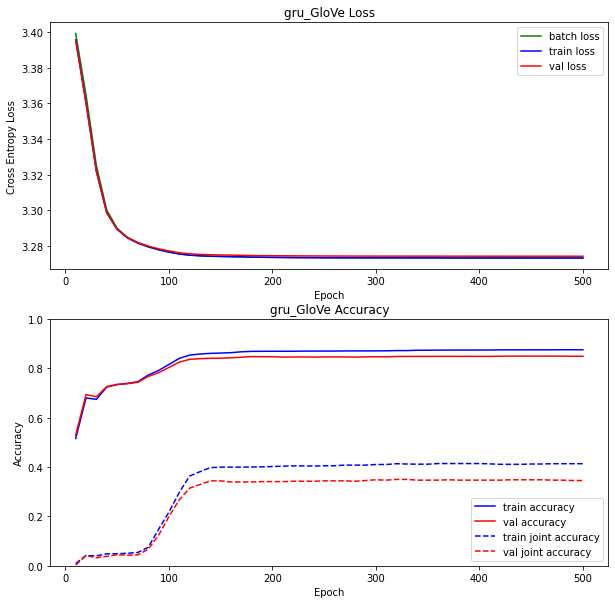

In [26]:
# GRU + GloVe
glove_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_glove_matrix(glove_map, utterance_slot_dataset.vocab)
)

gru_glove_model = GRUModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=glove_emb_layer,
).to(device)
gru_glove_reports = train(
    model=gru_glove_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(gru_glove_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="gru_GloVe",
)

10/500:	batch loss:  3.3715474605560303	train loss:  3.362797260284424	val loss:  3.3627259731292725	train accuracy:  0.6903420523138833	val accuracy:  0.6993155534576351	train joint accuracy:  0.041191381495564006	val joint accuracy:  0.04296296296296296
20/500:	batch loss:  3.298534870147705	train loss:  3.2970190048217773	val loss:  3.2967824935913086	train accuracy:  0.6787726358148893	val accuracy:  0.6839745102666981	train joint accuracy:  0.04055766793409379	val joint accuracy:  0.04148148148148148
30/500:	batch loss:  3.289669990539551	train loss:  3.2891199588775635	val loss:  3.2888545989990234	train accuracy:  0.7182092555331991	val accuracy:  0.7252773188576823	train joint accuracy:  0.050697084917617236	val joint accuracy:  0.045925925925925926
40/500:	batch loss:  3.283468246459961	train loss:  3.2830588817596436	val loss:  3.2829322814941406	train accuracy:  0.7190140845070423	val accuracy:  0.7255133349067736	train joint accuracy:  0.050697084917617236	val joint accurac

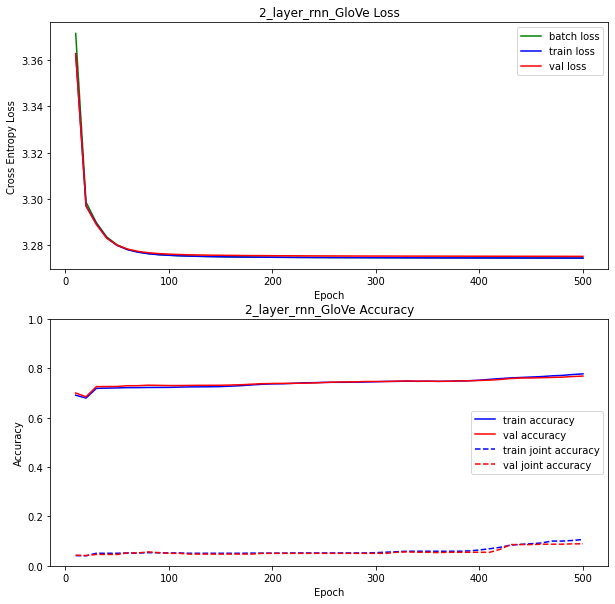

In [27]:
# 2 layer RNN + GloVe
glove_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_glove_matrix(glove_map, utterance_slot_dataset.vocab)
)

rnn_glove_model = RNNTwoLayerModel(
    input_size=embedding_dim,
    hidden_size=32,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=glove_emb_layer,
).to(device)
rnn_2_layer_glove_report = train(
    model=rnn_glove_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(rnn_glove_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="2_layer_rnn_GloVe",
)

10/500:	batch loss:  3.3991503715515137	train loss:  3.391969680786133	val loss:  3.3918354511260986	train accuracy:  0.6930583501006036	val accuracy:  0.7004956337030918	train joint accuracy:  0.0982256020278834	val joint accuracy:  0.08444444444444445
20/500:	batch loss:  3.3454272747039795	train loss:  3.338715076446533	val loss:  3.3385229110717773	train accuracy:  0.6878269617706237	val accuracy:  0.694359216426717	train joint accuracy:  0.0817490494296578	val joint accuracy:  0.08
30/500:	batch loss:  3.297283411026001	train loss:  3.29547119140625	val loss:  3.2952754497528076	train accuracy:  0.6729376257545272	val accuracy:  0.6759499645975926	train joint accuracy:  0.038656527249683145	val joint accuracy:  0.037037037037037035
40/500:	batch loss:  3.2859859466552734	train loss:  3.2853450775146484	val loss:  3.2853281497955322	train accuracy:  0.7261569416498994	val accuracy:  0.7269294312013217	train joint accuracy:  0.050697084917617236	val joint accuracy:  0.04592592592592

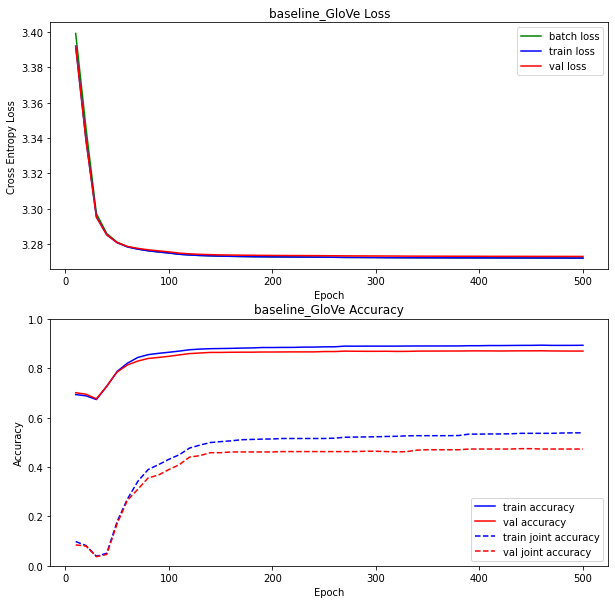

In [28]:
# Baseline RNN + GloVe
glove_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_glove_matrix(glove_map, utterance_slot_dataset.vocab)
)

baseline_glove_model = BaselineModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=glove_emb_layer,
).to(device)
baseline_glove_report = train(
    model=baseline_glove_model,
    n_epochs=500,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(baseline_glove_model.parameters(), lr=0.005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
    plot_name="baseline_GloVe",
)

10/500:	val accuracy:  0.9159663865546218	loss:  3.2751166820526123
20/500:	val accuracy:  0.9164465786314526	loss:  3.274977207183838
30/500:	val accuracy:  0.9171668667466987	loss:  3.2749581336975098
40/500:	val accuracy:  0.9190876350540216	loss:  3.2748756408691406
50/500:	val accuracy:  0.9195678271308524	loss:  3.2742817401885986
60/500:	val accuracy:  0.92124849939976	loss:  3.274354934692383
70/500:	val accuracy:  0.92124849939976	loss:  3.2740511894226074
80/500:	val accuracy:  0.921968787515006	loss:  3.2741012573242188
90/500:	val accuracy:  0.9231692677070829	loss:  3.2744081020355225
100/500:	val accuracy:  0.9250900360144058	loss:  3.273909330368042
110/500:	val accuracy:  0.9253301320528211	loss:  3.2740867137908936
120/500:	val accuracy:  0.9255702280912365	loss:  3.273796558380127
130/500:	val accuracy:  0.9260504201680673	loss:  3.2736318111419678
140/500:	val accuracy:  0.9262905162064826	loss:  3.2735233306884766
150/500:	val accuracy:  0.9270108043217287	loss:  3.

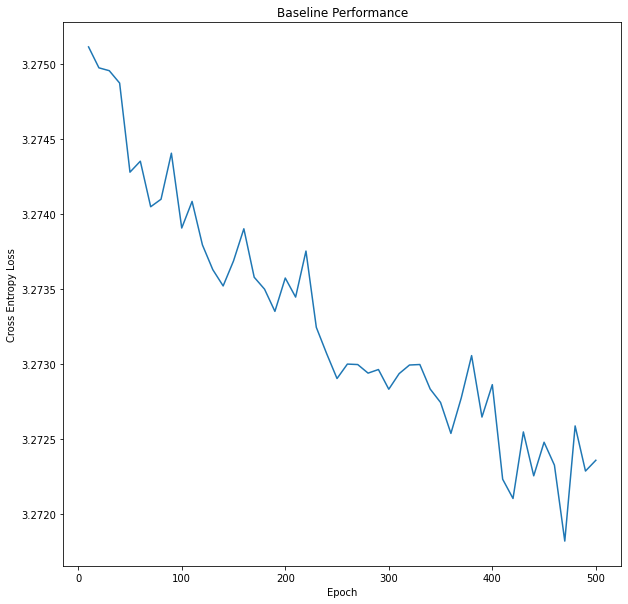

In [225]:
train(
    model=test_model,
    n_epochs=500,
    data_loader=all_train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(test_model.parameters(), lr=0.00005),
    val_set=val_set,
    dataset=utterance_slot_dataset,
    is_plot=True,
)

In [227]:
# Output Processing
def process_output_corpus(input_seqs, preds, trues):
    new_seqs = []
    new_preds = []
    new_trues = []
    for i in range(len(input_seqs)):
        new_seq, new_pred, new_true = remove_special_tokens(
            input_seqs[i], preds[i], trues[i]
        )
        new_seqs.append(new_seq)
        new_preds.append(new_pred)
        new_trues.append(new_true)
    return new_seqs, new_preds, new_trues


def remove_special_tokens(input_seq, pred, true):
    new_seq = []
    new_pred = []
    new_true = []
    new_seq = input_seq[1:-1]
    new_true = true[1:-1]
    new_pred = pred[1:]

    # if is truncated padding
    while len(new_pred) < len(new_seq):
        new_pred.append(PAD_TOKEN)

    # if is expanded padding
    while len(new_pred) > len(new_seq):
        new_pred = new_pred[:-1]

    return new_seq, new_pred, new_true


def convert_to_token(corpus, idx2token):
    return [[idx2token[token_idx] for token_idx in sent] for sent in corpus]


def preprocess_utterances(utterances, utterance_dataset):
    # tokenization
    utterances = tokenize(utterances)
    # add special tokens
    utterances = add_start_stop_tokens(utterances)
    tokenized_utterances = copy.deepcopy(utterances)
    # padding
    utterances = padding(utterances, utterance_dataset.seq_len)

    word2idx = utterance_dataset.word2idx
    utterances = [
        [word2idx.get(token, word2idx[UNK_TOKEN]) for token in sent]
        for sent in utterances
    ]

    return utterances, tokenized_utterances

In [228]:
test_df = pd.read_csv("test_data.csv")
test_utterances = list(test_df["utterances"])
test_input, test_input_seqs = preprocess_utterances(
    test_utterances, utterance_slot_dataset
)
test_X = torch.tensor(test_input).to(device)

In [229]:
test_pred = inference(test_model, test_X)

In [230]:
# input_seqs = convert_to_token(test_X.tolist(), utterance_slot_dataset.idx2word)
preds = convert_to_token(test_pred.tolist(), utterance_slot_dataset.idx2slot)
test_input_seqs, preds, _ = process_output_corpus(
    test_input_seqs, preds, preds
)

In [231]:
len([slot for seq in preds for slot in seq])

6415

In [233]:
for i, sent in enumerate(test_input_seqs):
    if len(sent) != len(test_utterances[i].split()):
        print(sent, test_utterances[i])

In [234]:
for pred in preds:
    for i, slot in enumerate(pred):
        if slot in SPECIAL_TOKENS:
            pred[i] = "O"

In [235]:
all_slots = [slot for seq in preds for slot in seq]

In [236]:
len(all_slots)

6415

In [237]:
indexes = list(range(len(all_slots)))

In [238]:
output_df = pd.DataFrame({"Id": indexes, "Predicted": all_slots})

In [239]:
output_df.to_csv("2_layer_rnn.csv", index=False)